Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# jax4dc Part I: Trajectory optimization in Jax

This notebook accompanies the first part of the jax4dc tutorial presented at [L4DC 2023](https://l4dc.seas.upenn.edu/tutorials/).

Authors: Roy Frostig, Sumeet Singh, and Stephen Tu

In [1]:
# install necessary dependencies
%pip install -r requirements.txt

  Cloning https://github.com/google/trajax to /tmp/pip-req-build-7qhd3lj4
  Running command git clone --filter=blob:none --quiet https://github.com/google/trajax /tmp/pip-req-build-7qhd3lj4
  Resolved https://github.com/google/trajax to commit c94a637c5a397b3d4100153f25b4b165507b5b20
  Installing build dependencies ...   Resolved https://github.com/google/trajax to commit c94a637c5a397b3d4100153f25b4b165507b5b20
  Installing build dependencies ... -done
  Getting requirements to build wheel ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (pyproject.toml) ... -done
done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import jax

# from jax.config import config
jax.config.update('jax_enable_x64', True)

from dataclasses import dataclass
from functools import partial
from typing import Any, Callable, Sequence

import chex
from flax import struct
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pylab as plt
import numpy as np
import pprint
import optax
import scipy as sp
import tqdm
import time

from brax import envs, State
from brax.envs import Env
from brax.io import html
from optax import OptState, TransformUpdateFn
from trajax.integrators import euler
from trajax.optimizers import ilqr

from IPython.display import HTML, IFrame

Array = jax.Array
PRNGKey = chex.PRNGKey
PyTree = Any
Scalar = chex.Scalar

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


## Building blocks

We first build several primitives for optimal control:

- `rollout`: given inputs $U$ and initial state $x_0$, rollout a trajectory $X$.
- `trajectory_cost`: given a trajectory $X$ generated by inputs $U$, compute the cost. 
- `objective`: given inputs $U$ and initial state $x_0$, compute the cost of the resulting trajectory.

Unlike the tutorial slides, we will work with a more general representation of the state as an abstract [PyTree](https://jax.readthedocs.io/en/latest/pytrees.html). The input remains a concrete `Array`.

In [6]:
# f(t, x, u)
Dynamics = Callable[[Scalar, PyTree, Array], PyTree]

# c(t, x, u)
StageCost = Callable[[Scalar, PyTree, Array], float]
# c(t, x)
TerminalCost = Callable[[Scalar, PyTree], float]


@dataclass
class Cost:
    stage_cost: StageCost
    terminal_cost: TerminalCost


def rollout(dynamics: Dynamics, U: Array, x0: PyTree) -> PyTree:
    """Unrolls `X[t+1] = dynamics(t, X[t], U[t])`, where `X[0] = x0`."""

    def step(x, args):
        t, u = args
        x = dynamics(t, x, u)
        return x, x  # Return (carry, emitted state)

    _, X = jax.lax.scan(step, x0, (jnp.arange(len(U)), U))
    return X


def trajectory_cost(cost: Cost, U: Array, x0: PyTree, X: PyTree) -> float:
    T = len(U)
    time_steps = jnp.arange(T)
    X = jax.tree.map(
        lambda a, b: jnp.concatenate((a[None, :], b), axis=0), x0, X)
    stage_cost = jnp.sum(jax.vmap(cost.stage_cost)(
        time_steps, jax.tree.map(lambda leaf: leaf[:-1], X), U))
    terminal_cost = cost.terminal_cost(
        T, jax.tree.map(lambda leaf: leaf[-1], X))
    return stage_cost + terminal_cost


def objective(
    dynamics: Dynamics, cost: Cost, U: Array, x0: PyTree
) -> float:
    X = rollout(dynamics, U, x0)
    return trajectory_cost(cost, U, x0, X)


def pytree_block_until_ready(tree: PyTree) -> PyTree:
    return jax.tree.map(lambda leaf: leaf.block_until_ready(), tree)


def print_jit_and_eval_times(f, *, args=(), kwargs={}, name='', num_steps=5):
    start_time = time.time()
    pytree_block_until_ready(f(*args, **kwargs))
    jit_plus_eval_time = time.time() - start_time

    start_time = time.time()
    for _ in range(num_steps):
        pytree_block_until_ready(f(*args, **kwargs))
    eval_time = (time.time() - start_time) / num_steps
    print(
        f"{name}, jit_time={jit_plus_eval_time - eval_time:.3f} (s), eval_time={eval_time:.3f} (s)")


## Brax setup

We will use [`brax`](https://github.com/google/brax), a Jax-based differentiable physics simulator, to provide concrete implementations of dynamics functions.

We first write some helper functions to make `brax` compatible with our abstractions. One issue that will arise, is that `brax.State` objects are PyTrees which are not minimal: they contain derived information (e.g. transformations) from the generalized coordinates. Since later we will want to linearize the dynamics and quadratize the costs, we want to do this in generalized coordinates, so we define some conversion functions to go between the two representations.

In [7]:
def state_to_gen_coords(state: State) -> Array:
    return jnp.concatenate((state.q, state.qd))


def gen_coords_to_state(env: Env, coords: Array) -> State:
    q, qd = jnp.split(coords, [env.sys.q_size()])
    return env.pipeline_init(q, qd)


def brax_dynamics(
        env: Env, t: Scalar, x: State, u: Array) -> Array:
    return env.pipeline_step(x, u)


## Reacher environment cost/dynamics

For the majority of this notebook, we will focus on the reacher environment. 

Here, we define the dynamics and cost functions associated with reacher.

In [8]:
reacher_env = envs.get_environment(
    env_name='reacher',    # 'reacher', 'ant', ...
    backend='positional',  # 'generalized', 'positional', ...
)

dynamics = partial(brax_dynamics, reacher_env)
trajectory = jax.jit(partial(rollout, dynamics))
coords_to_state = jax.jit(partial(gen_coords_to_state, reacher_env))

/home/andrea-ostuni/jax_ws/.venv_jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [9]:
@struct.dataclass
class ReacherCostParams:
    # stage cost weights
    stage_pos: float = 10.0
    stage_vel: float = 0.001
    stage_act: float = 0.01

    # terminal cost weights
    term_pos: float = 100.0
    term_vel: float = 10.0


In [10]:
def reacher_stage_cost(
    t: Scalar, x: State, u: Array, *, params: ReacherCostParams
) -> float:
    obs = reacher_env._get_obs(x)  # get access to goal
    state_cost = 0.0

    # distance to goal
    state_cost += params.stage_pos * jnp.sum(obs[8:10] ** 2)

    # angular velocity of arm
    state_cost += params.stage_vel * jnp.sum(obs[6:8] ** 2)

    # actuation penalty
    act_cost = params.stage_act * jnp.sum(u ** 2)
    return state_cost + act_cost


def reacher_terminal_cost(
    t: Scalar, x: State, *, params: ReacherCostParams
) -> float:
    obs = reacher_env._get_obs(x)
    state_cost = 0.0

    # distance to goal
    state_cost += params.term_pos * jnp.sum(obs[8:10] ** 2)

    # angular velocity of arm
    state_cost += params.term_vel * jnp.sum(obs[6:8] ** 2)
    return state_cost


In [11]:
@jax.jit
def value_and_grad_obj(
    U: Array, x0: PyTree, params: ReacherCostParams
) -> tuple[float, Array]:
    cost = Cost(
        stage_cost=partial(reacher_stage_cost, params=params),
        terminal_cost=partial(reacher_terminal_cost, params=params))
    obj = partial(objective, dynamics, cost)
    return jax.value_and_grad(obj)(U, x0)


## Gradient methods

We are now ready to write our first trajectory optimizer based on first-order methods. We will use [`optax`](https://github.com/deepmind/optax) to abstract away the details of specific optimization algorithms such as gradient descent, Adam, AdaGrad, etc. 

In [12]:
def gradient_step(
    update: TransformUpdateFn,
    U: Array,
    opt_state: OptState,
    x0: Array,
    params: ReacherCostParams
) -> tuple[float, Array, Array, OptState]:
    v, g = value_and_grad_obj(U, x0, params)
    U, opt_state = optax_step(update, U, opt_state, g)
    return v, g, U, opt_state


def optax_step(
    update: TransformUpdateFn,
    params: Array,
    opt_state: OptState,
    gradient: Array,
):
    updates, opt_state = update(gradient, opt_state, params)
    # params += updates
    params = optax.apply_updates(params, updates)
    return params, opt_state


In [13]:
opt = optax.adam(learning_rate=5e-2)  # or optax.sgd, ...
step = jax.jit(partial(gradient_step, opt.update))

We now define the task horizon, the initial state $x_0$, the initial guess for the sequence of inputs $U$,
and the parameters we will use for the reacher cost function.

In [14]:
T = 40
x0 = reacher_env.pipeline_init(
    jnp.array([0, 0, -0.05, -0.20]),
    
    # other initial conditions to try:
    # jnp.array([0, 0, -0.05, -0.15]),
    # jnp.array([0, 0, -0.1, -0.15]),
    # reacher_env.sys.init_q,
    
    jnp.zeros((4,))
)
U = jax.random.uniform(
    jax.random.PRNGKey(0),
    minval=-0.1,
    maxval=0.1,
    shape=(T, reacher_env.action_size),
)
params = ReacherCostParams(term_pos=1000.0, term_vel=500.0)


One current downside of using `brax` is that compile times are fairly long. On the other hand, evaluation is very fast. We illustrate this below.

In [12]:
print_jit_and_eval_times(
    step, 
    args=(U, opt.init(U), x0, params),
    name='step')

step, jit_time=36.456 (s), eval_time=0.204 (s)


Now that our main `step` function is compiled, we can run our optimization algorithm. Here, we run 500 steps of Adam, recording both the objective values and $\ell_\infty$ gradient norms throughout the optimization.

In [13]:
opt_state = opt.init(U)
values = []
grad_norms = []
for iteration in tqdm.tqdm(range(500)):
    v, g, U, opt_state = step(U, opt_state, x0, params)
    values.append(v)
    grad_norms.append(np.linalg.norm(g, ord=np.inf))

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


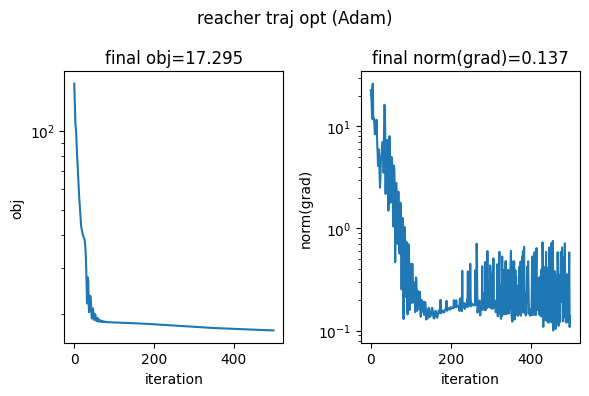

In [14]:
plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
plt.semilogy(values)
plt.xlabel('iteration')
plt.ylabel('obj')
plt.title(f'final obj={values[-1]:.3f}')

plt.subplot(1, 2, 2)
plt.semilogy(grad_norms)
plt.xlabel('iteration')
plt.ylabel('norm(grad)')
plt.title(f'final norm(grad)={grad_norms[-1]:.3f}')

plt.suptitle('reacher traj opt (Adam)')

plt.tight_layout()

Let us now visualize the resulting trajectory!

In [15]:
X = trajectory(U, x0)
X = jax.tree.map(
    lambda a, b: jnp.concatenate((a[None, :], b), axis=0), x0, X)

In [16]:
# Note: writing the result of `html.render` is only necessary in a jupyter notebook.
# If running as a colab notebook, one can directly write `HTML(html.render(...))`. 
# This is a known issue: https://github.com/google/brax/issues/114
with open('temp_optax.html', 'w') as fp:
    # we replace the `dt` value to 0.1 so that the visualization runs at a reasonable speed.
    fp.write(html.render(reacher_env.sys,
                         [coords_to_state(x) for x in jax.vmap(state_to_gen_coords)(X)]))
IFrame('temp_optax.html', width=900, height=500)

## Scipy L-BFGS

Next, we turn to a more classic optimization algorithm, [limited memory BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) (L-BFGS).

We rely on scipy's `optimize.fmin_l_bfgs_b` implementation, which takes as input user defined functions that represent both function and gradient evaluation. This is the same as our `value_and_grad_obj` function, with a few caveats: scipy's implementation requires both (a) vector parameters and (b) float64 precision. Hence, we need a small wrapper to make our `value_and_grad_obj` function compatible.

In [17]:
def scipy_obj(flat_U: np.ndarray, *,
              x0: State, params: ReacherCostParams) -> tuple[float, np.ndarray]:
    """Interface between L-BFGS and Jax."""
    U = flat_U.reshape((-1, reacher_env.action_size))  # unflatten
    v, g = value_and_grad_obj(U, x0, params)
    return (
        float(v),
        np.array(jax.device_get(g), dtype=np.float64).flatten())


In [18]:
print_jit_and_eval_times(
    value_and_grad_obj,
    args=(U, x0, params),
    name='value_and_grad_obj')

value_and_grad_obj, jit_time=32.592 (s), eval_time=0.201 (s)


We can now call `scipy.optimize.fmin_l_bfgs_b` to solve our trajectory optimization problem.

In [19]:
U = jax.random.uniform(
    jax.random.PRNGKey(0),
    minval=-0.1,
    maxval=0.1,
    shape=(T, reacher_env.action_size),
)

flat_U, f_star, info = sp.optimize.fmin_l_bfgs_b(
    partial(scipy_obj, x0=x0, params=params), 
    jax.device_get(U.flatten()))
U = flat_U.reshape(U.shape)

In [20]:
print("norm(grad)", np.linalg.norm(info['grad'], ord=np.inf))
print("num_iters", info['nit'])
print("obj", f_star)

norm(grad) 0.4850224735448283
num_iters 291
obj 17.060604281059433


As before, let us now visualize the resulting optimal trajectory.

In [21]:
X = trajectory(U, x0)
X = jax.tree.map(lambda a, b: jnp.concatenate((a[None, :], b), axis=0), x0, X)

In [22]:
# Same comment regarding the tempfile+IFrame workaround from visualizing
# the result of the optax optimization applies here.
with open('temp_lbfgs.html', 'w') as fp:
    fp.write(html.render(reacher_env.sys,
                         [coords_to_state(x) for x in jax.vmap(state_to_gen_coords)(X)]))
IFrame('temp_lbfgs.html', width=900, height=500)

## Trajax iLQR

We've successfully used both Adam and L-BFGS to solve the reacher trajectory optimization problem. For more challenging problems, first-order methods can be quite inefficient, and incorporating second-order information can dramatically improve the computational complexity of optimization. 

The iterative Linear Quadratic Regulator (iLQR) algorithm is a classic algorithm for trajectory optimization which incorporates second-order information. It is described in more detail in Part II of our tutorial. For now, we will use our [`trajax`](https://github.com/google/trajax) library, which implements iLQR using Jax, so that it is compatible with Jax's transforms and supports automatic differentiation.  

We first start with `ilqr_solve`, a thin wrapper around `trajax.optimizers.ilqr` which handles the slight API mismatch between our `Cost` and `Dynamics` type signatures, and what `trajax` expects as inputs. The biggest issue this wrapper resolves is forcing `trajax` to deal with only the generalized coordinates, instead of the `brax.State` PyTree. This is specifically for efficiency reasons, so we do not have to automatically differentiate through the derived information when we linearize the dynamics and quadratize the cost. 

In [15]:
@jax.jit
def ilqr_solve(x0: Array, U: Array, params: ReacherCostParams) -> ...:

    cost = Cost(
        stage_cost=partial(reacher_stage_cost, params=params),
        terminal_cost=partial(reacher_terminal_cost, params=params))

    def trajax_cost(
        x: Array, u: Array, t: Scalar
    ) -> float:
        x = coords_to_state(x)
        return jnp.where(
            t == T,
            cost.terminal_cost(t, x),
            cost.stage_cost(t, x, u))

    def trajax_dynamics(
        x: Array, u: Array, t: Scalar
    ) -> Array:
        # (x, u, t) -> (t, x, u)
        x = coords_to_state(x)
        return state_to_gen_coords(dynamics(t, x, u))

    ilqr_kwargs = dict(
        make_psd=True, psd_delta=1e-4, alpha_0=0.5
    )

    return ilqr(trajax_cost, trajax_dynamics, x0, U, **ilqr_kwargs)


The slow compile times previously encountered are further exacerbated when combining `brax` with `trajax`, as shown below. Nevertheless, the compiled code is very fast.

In [24]:
print_jit_and_eval_times(
    ilqr_solve,
    args=(state_to_gen_coords(x0), U, params),
    name='ilqr_solve',
    num_steps=1)

ilqr_solve, jit_time=122.493 (s), eval_time=0.404 (s)


In [25]:
U = jax.random.uniform(
    jax.random.PRNGKey(0),
    minval=-0.1,
    maxval=0.1,
    shape=(T, reacher_env.action_size),
)
X, U, obj, grad, *_ = ilqr_solve(state_to_gen_coords(x0), U, params)

In [26]:
print('norm(grad)', np.linalg.norm(grad, ord=np.inf))
print('obj', obj)

norm(grad) 3.4034888898036706
obj 41.585812566729324


As before, let us visualize the optimal trajectory.

In [27]:
# Again, the tempfile+IFrame workaround is unnecessary if we run 
# this notebook as a colab notebook.
with open('temp_trajax.html', 'w') as fp:
    fp.write(html.render(reacher_env.sys, [coords_to_state(x) for x in X]))
IFrame('temp_trajax.html', width=900, height=500)

The fact that the entire `ilqr` routine is written in Jax allows us to write various Jax transformations on top of `ilqr`. This has some pretty neat implications in terms of e.g. parallel simulation and cost parameter optimization. 

For what follows, we conduct a very simple form of cost parameter optimization via grid-search. In particular, we will seek the set of cost parameters which minimizes the worst-case goal error over several fixed initial conditions $x_0$.

In [28]:
x0s = jnp.array([
    [0, 0, 0.1, -0.1],
    [0, 0, 0.17, 0.1],
    [0, 0, 0.0, -0.20]
])
x0s = jax.vmap(partial(reacher_env.pipeline_init, qd=jnp.zeros((4,))))(x0s)
x0s = jax.vmap(state_to_gen_coords)(x0s)

In [29]:
def meta_cost(params: ReacherCostParams, x0s: Array, key: PRNGKey) -> float:
    U = jax.random.uniform(
        key, minval=-0.1, maxval=0.1,
        shape=(T, reacher_env.action_size))
    Xs, Us, objs, grads, adjoints, lqrs, iters = jax.vmap(
        ilqr_solve, in_axes=(0, None, None))(x0s, U, params)
    states = jax.vmap(coords_to_state)(Xs[:, -1, :])
    obs = jax.vmap(reacher_env._get_obs)(states)
    c = jnp.max(jnp.sum(obs[:, 8:10] ** 2, axis=-1))
    return c, (Xs, Us, objs, grads, adjoints, lqrs, iters)


In [30]:
vmap_meta_cost = jax.jit(jax.vmap(meta_cost, in_axes=(0, None, None)))

def reacher_cost_from_weight(w: float) -> ReacherCostParams:
    return ReacherCostParams(term_pos=w)

weights = jnp.array([100.0, 500.0, 1000.0])

In [31]:
args = (
    jax.vmap(reacher_cost_from_weight)(weights),
    x0s,
    jax.random.PRNGKey(17))
print_jit_and_eval_times(
    vmap_meta_cost,
    args=args,
    name='vmap_meta_cost',
    num_steps=1
)

vmap_meta_cost, jit_time=173.368 (s), eval_time=49.675 (s)


In [32]:
meta_costs, meta_results = vmap_meta_cost(
    jax.vmap(reacher_cost_from_weight)(weights),
    x0s,
    jax.random.PRNGKey(17))

In [33]:
best_idx = np.argmin(meta_costs)
print("best_idx", best_idx)

best_idx 2


In [34]:
x0_idx = 2  # indexes into x0s
with open('temp_meta_cost.html', 'w') as fp:
    fp.write(html.render(
        reacher_env.sys, 
        [coords_to_state(x) for x in meta_results[0][best_idx][x0_idx]]))
IFrame('temp_meta_cost.html', width=900, height=500)

## Acrobot iLQR sensitivity analysis

We now conclude by exploring the autodiff capabilites of `trajax`. In particular, we take advantage of the fact that `trajax` supports autodiff through the solution of iLQR problems.

In the following example, we consider a standard [acrobot](http://underactuated.mit.edu/acrobot.html#section1) swingup task. We study which parameters of both the cost and dynamics function has the biggest influence on the amount of optimal control effort ($\sum_t \|u_t\|^2$) needed to swing the acrobot up.

We first start by defining acrobot dynamics. We do not use `brax` here for clarity reasons because we want the mapping between parameters and dynamics to be explicit.  

In [35]:
@struct.dataclass
class AcrobotDynamicsParams:
    
    LINK_MASS_1: float = 1.0
    LINK_MASS_2: float = 1.0
    LINK_LENGTH_1: float = 1.0
    LINK_COM_POS_1: float = 0.5
    LINK_COM_POS_2: float = 0.5
    LINK_MOI_1: float = 1.0
    LINK_MOI_2: float = 1.0


def acrobot(
    x: Array,
    u: Array,
    t: Scalar,
    params: AcrobotDynamicsParams
) -> Array:
    """Classic Acrobot system.

    Note this implementation emulates the OpenAI gym implementation of
    Acrobot-v2, which itself is based on Stutton's Reinforcement Learning book.

    Args:
      x: state, (4, ) array
      u: control, (1, ) array
      t: scalar time. Disregarded because system is time-invariant.
      params: tuple of (LINK_MASS_1, LINK_MASS_2, LINK_LENGTH_1, LINK_COM_POS_1,
        LINK_COM_POS_2 LINK_MOI_1, LINK_MOI_2)

    Returns:
      xdot: state time derivative, (4, )
    """
    del t  # Unused

    m1, m2, l1, lc1, lc2, I1, I2 = jax.flatten_util.ravel_pytree(params)[0]
    g = 9.8
    a = u[0]
    theta1 = x[0]
    theta2 = x[1]
    dtheta1 = x[2]
    dtheta2 = x[3]
    d1 = (
        m1 * lc1**2 + m2 * (l1**2 + lc2**2 + 2 * l1 * lc2 * jnp.cos(theta2)) + I1 +
        I2)
    d2 = m2 * (lc2**2 + l1 * lc2 * jnp.cos(theta2)) + I2
    phi2 = m2 * lc2 * g * jnp.cos(theta1 + theta2 - jnp.pi / 2.)
    phi1 = (-m2 * l1 * lc2 * dtheta2**2 * jnp.sin(theta2) -
            2 * m2 * l1 * lc2 * dtheta2 * dtheta1 * jnp.sin(theta2) +
            (m1 * lc1 + m2 * l1) * g * jnp.cos(theta1 - jnp.pi / 2) + phi2)
    ddtheta2 = ((a + d2 / d1 * phi1 -
                 m2 * l1 * lc2 * dtheta1**2 * jnp.sin(theta2) - phi2) /
                (m2 * lc2**2 + I2 - d2**2 / d1))
    ddtheta1 = -(d2 * ddtheta2 + phi1) / d1
    return jnp.array([dtheta1, dtheta2, ddtheta1, ddtheta2])


We now define a cost function, which penalizes deviations of the acrobot from the upright position.

In [36]:
T = 50
goal = jnp.array([jnp.pi, 0.0, 0.0, 0.0])


@struct.dataclass
class AcrobotCostParams:
    stage_cost_x: float = 0.1
    stage_cost_u: float = 0.01
    term_cost_x: float = 1000.0


def acrobot_cost(
    x: Array,
    u: Array,
    t: Scalar,
    params: AcrobotCostParams
) -> float:
    delta = x - goal
    terminal_cost = 0.5 * params.term_cost_x * jnp.dot(delta, delta)
    stage_cost = 0.5 * params.stage_cost_x * jnp.dot(
        delta, delta) + 0.5 * params.stage_cost_u * jnp.dot(u, u)
    return jnp.where(t == T, terminal_cost, stage_cost)


The following `acrobot_control_effort` function takes in `dynamics_params` and `cost_params`, solves the resulting `ilqr` problem after applying a 
[forward Euler](https://en.wikipedia.org/wiki/Euler_method) discretization
to the continuous acrobot dynamics to turn it into a discrete problem, and then returns
the optimal control effort $\sum_t \|u_t\|^2$.

In [37]:
def acrobot_control_effort(
    dynamics_params: AcrobotDynamicsParams, 
    cost_params: AcrobotCostParams
) -> float:
    dynamics = euler(
        partial(acrobot, params=dynamics_params), dt=0.1)
    x0 = jnp.zeros(4)
    U = jnp.zeros((T, 1))
    _, U, *_ = ilqr(
        partial(acrobot_cost, params=cost_params),
        dynamics, x0, U,
        maxiter=100, make_psd=False, vjp_method='explicit')
    return jnp.sum(U ** 2)


In [38]:
# This helper class allows us to pretty print dataclasses
# Taken from:
# https://stackoverflow.com/questions/44356693/pprint-with-custom-float-formats
class FormatPrinter(pprint.PrettyPrinter):

    def __init__(self, formats):
        super(FormatPrinter, self).__init__()
        self.formats = formats

    def format(self, obj, ctx, maxlvl, lvl):
        if type(obj) in self.formats:
            return self.formats[type(obj)] % obj, 1, 0
        return pprint.PrettyPrinter.format(self, obj, ctx, maxlvl, lvl)
printer = FormatPrinter({float: '%.3f'})


We can now answer our question of which parameters have the most effect on the optimal control effort, by taking a gradient of the `acrobot_control_effort` function, w.r.t. both the `dynamics_params` and the `cost_params`. For the `cost_params`, the answer is perhaps obvious; it should be the `stage_cost_u` parameter which penalizes control effort. However, for the dynamics parameters, it is not a-priori obvious what the answer should be.

In [39]:
dynamics_params = AcrobotDynamicsParams()
cost_params = AcrobotCostParams()
dynamics_grad = jax.grad(acrobot_control_effort, argnums=0)(
    dynamics_params, cost_params)
printer.pprint(jax.tree.map(float, dynamics_grad))


AttributeError: jax.tree_map was removed in JAX v0.6.0: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).

Here, we see that the `LINK_COM_POS_2` parameter has the most influence. Turning to the cost parameters, we see that our intuition is indeed correct.

In [ ]:
cost_grad = jax.grad(acrobot_control_effort, argnums=1)(
    dynamics_params, cost_params)
printer.pprint(jax.tree.map(float, cost_grad))


AttributeError: jax.tree_map was removed in JAX v0.6.0: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).

In [17]:
import jax
import os
import time
import gc
import psutil
from contextlib import nullcontext

process = psutil.Process(os.getpid())


def mem_mb():
    return process.memory_info().rss / (1024 ** 2)


def cpu_percent(duration=0.5):
    process.cpu_percent(interval=None)
    return process.cpu_percent(interval=duration)


def profile_runtime(device=None):
    if isinstance(device, str):
        available = jax.devices(device)
        if not available:
            raise RuntimeError(f"No {device} devices found.")
        target = available[0]
        device_kind = device
    elif device is None:
        target = None
        device_kind = jax.default_backend()
    else:
        target = device
        device_kind = device.platform

    context = jax.default_device(target) if target else nullcontext()

    with context:
        local_U = jax.device_put(U, target) if target else U
        local_x0 = jax.device_put(x0, target) if target else x0
        local_params = jax.device_put(params, target) if target else params
        x0_coords = state_to_gen_coords(local_x0)

        warm_opt_state = opt.init(local_U)
        pytree_block_until_ready(step(local_U, warm_opt_state, local_x0, local_params))
        pytree_block_until_ready(value_and_grad_obj(local_U, local_x0, local_params))
        pytree_block_until_ready(ilqr_solve(x0_coords, local_U, local_params))

        gc.collect()
        baseline_mem = mem_mb()
        baseline_cpu = cpu_percent(0.1)

        opt_state_tmp = opt.init(local_U)

        start = time.perf_counter()
        step_outputs = step(local_U, opt_state_tmp, local_x0, local_params)
        pytree_block_until_ready(step_outputs)
        step_eval = time.perf_counter() - start
        step_mem = mem_mb()
        step_cpu = cpu_percent(0.1)

        start = time.perf_counter()
        vg_outputs = value_and_grad_obj(local_U, local_x0, local_params)
        pytree_block_until_ready(vg_outputs)
        value_grad_eval = time.perf_counter() - start
        value_grad_mem = mem_mb()
        value_grad_cpu = cpu_percent(0.1)

        start = time.perf_counter()
        ilqr_outputs = ilqr_solve(x0_coords, local_U, local_params)
        pytree_block_until_ready(ilqr_outputs)
        ilqr_eval = time.perf_counter() - start
        ilqr_mem = mem_mb()
        ilqr_cpu = cpu_percent(0.1)

    return {
        "device_kind": device_kind,
        "device": str(target or jax.devices()[0]),
        "baseline_mem_mb": baseline_mem,
        "baseline_cpu_pct": baseline_cpu,
        "step_eval_s": step_eval,
        "step_mem_mb": step_mem,
        "step_cpu_pct": step_cpu,
        "value_grad_eval_s": value_grad_eval,
        "value_grad_mem_mb": value_grad_mem,
        "value_grad_cpu_pct": value_grad_cpu,
        "ilqr_eval_s": ilqr_eval,
        "ilqr_mem_mb": ilqr_mem,
        "ilqr_cpu_pct": ilqr_cpu,
    }

In [18]:
profiles = {}
profiles["cpu"] = profile_runtime("cpu")

try:
    gpu_device = jax.devices("gpu")[0]
except (RuntimeError, IndexError):
    gpu_device = None

if gpu_device is not None:
    profiles["gpu"] = profile_runtime(gpu_device)
else:
    print("No GPU detected; skipping GPU profiling.")

for kind, metrics in profiles.items():
    print(f"{kind.upper()} results:")
    for key, value in metrics.items():
        if isinstance(value, (int, float, np.floating)):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
    print()

if "cpu" in profiles and "gpu" in profiles:
    print("Relative speedups (CPU time / GPU time):")
    for metric in ("step_eval_s", "value_grad_eval_s", "ilqr_eval_s"):
        cpu_val = profiles["cpu"][metric]
        gpu_val = profiles["gpu"][metric]
        if gpu_val > 0:
            print(f"  {metric}: {cpu_val / gpu_val:.2f}x")

    print("Memory usage delta (CPU - GPU) in MB:")
    for metric in ("step_mem_mb", "value_grad_mem_mb", "ilqr_mem_mb"):
        cpu_mem = profiles["cpu"][metric]
        gpu_mem = profiles["gpu"][metric]
        print(f"  {metric}: {cpu_mem - gpu_mem:.1f}")

CPU results:
  device_kind: cpu
  device: TFRT_CPU_0
  baseline_mem_mb: 11838.2734
  baseline_cpu_pct: 10.0000
  step_eval_s: 0.0413
  step_mem_mb: 11838.2734
  step_cpu_pct: 0.0000
  value_grad_eval_s: 0.0277
  value_grad_mem_mb: 11838.2734
  value_grad_cpu_pct: 0.0000
  ilqr_eval_s: 5.4504
  ilqr_mem_mb: 11838.6484
  ilqr_cpu_pct: 0.0000

GPU results:
  device_kind: gpu
  device: cuda:0
  baseline_mem_mb: 11838.6484
  baseline_cpu_pct: 0.0000
  step_eval_s: 0.2162
  step_mem_mb: 11838.6484
  step_cpu_pct: 0.0000
  value_grad_eval_s: 0.2094
  value_grad_mem_mb: 11838.6484
  value_grad_cpu_pct: 0.0000
  ilqr_eval_s: 12.0701
  ilqr_mem_mb: 11838.6484
  ilqr_cpu_pct: 0.0000

Relative speedups (CPU time / GPU time):
  step_eval_s: 0.19x
  value_grad_eval_s: 0.13x
  ilqr_eval_s: 0.45x
Memory usage delta (CPU - GPU) in MB:
  step_mem_mb: -0.4
  value_grad_mem_mb: -0.4
  ilqr_mem_mb: 0.0
